# MRI Normalisation

To ensure brain slices align throughout the samples we can warp the MRI volumes to fit a template.

Two main approaches are using `ANTs` and `SPM12`, with the first being more accurate but being more computationally expensive than the latter.

In [92]:
import os
import time
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from nipype.interfaces.spm import Normalize12
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.misc import Gunzip
from nipype.pipeline.engine import Workflow, Node, MapNode
from nipype.interfaces.freesurfer import MRIConvert
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/usr/local/MATLAB/R2014a/toolbox/spm12')
MatlabCommand.set_default_matlab_cmd("matlab -nodesktop -nosplash")

## Normalisation with `SPM-12`

Using `SPM` to normalise the data is a lot faster and simpler than the `ANTs` method. Although it may produce less accurate results, it is likely a better fit for normalising a large dataset such as ours.

First we will need to specify the working directories.

In [18]:
input_subject = "/mnt/HDD/Data/nipype_test/input/uncompressed/sub002.nii"
input_template = "/mnt/HDD/Data/nipype_test/templates/study_templates/Oasis/MICCAI2012-Multi-Atlas-Challenge-Data/T_template0.nii.gz"

#### Normalise

Create the normalisation object.

In [19]:
norm12 = Normalize12()
norm12.inputs.image_to_align = input_subject
norm12.inputs.tpm = input_template

Run the normalisation.

In [20]:
norm12.run()

#### Analyse output

Now we can look at the output.

In [28]:
norm_outputs = norm12.aggregate_outputs()
norm_outputs


deformation_field = /mnt/HDD/Data/nipype_test/input/uncompressed/y_sub002.nii
normalized_files = <undefined>
normalized_image = /mnt/HDD/Data/nipype_test/input/uncompressed/wsub002.nii

Now we can examine the output

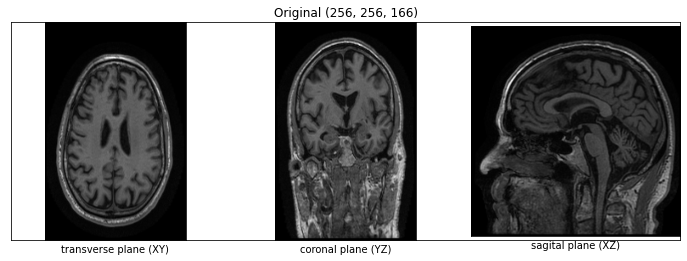

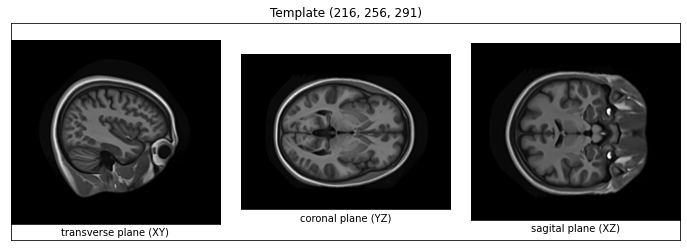

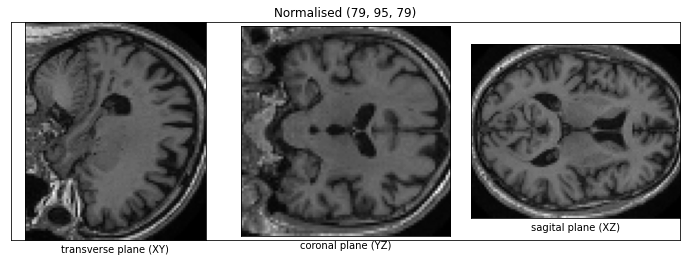

In [72]:
for title, path in [("Original", input_subject), ("Template", input_template), ("Normalised", norm_outputs.normalized_image)]:
    norm_nii = nib.load(path)
    volume = norm_nii.get_fdata()
    transverse_slice = ("transverse plane (XY)", volume[volume.shape[0] // 3, :, :]) 
    coronal_slice = ("coronal plane (YZ)", volume[:, volume.shape[1] // 2, :])
    sagital_slice = ("sagital plane (XZ)", volume[:, :, volume.shape[2] // 2])
    fig = plt.figure(figsize=(12, 4))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.title("{0} {1}".format(title, volume.shape))
    plt.xticks([])
    plt.yticks([])
    for i, (plane, img) in enumerate([transverse_slice, coronal_slice, sagital_slice]):
        ax = fig.add_subplot(1, 3, i+1)
        ax.imshow(img, cmap='gray')
        ax.set_xticks([]) 
        ax.set_yticks([])
        ax.set_xlabel(plane)
    plt.show()

## Resample inputs

From the outputs it is evident that the template and input MRI dimensions are not aligned. We will need to reformat the template to match the sample dimensions.

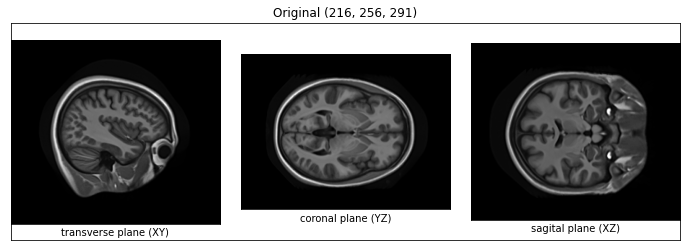

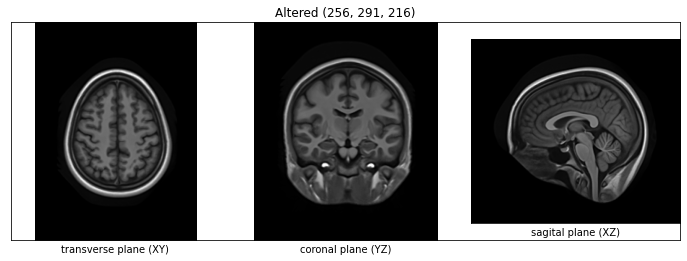

In [91]:
norm_nii = nib.load(input_template)
volume_org = norm_nii.get_fdata()

volume_alt = np.swapaxes(volume_org, 0, 1)
volume_alt = np.swapaxes(volume_alt, 1, 2)
volume_alt = np.flip(volume_alt, axis=1)

for (title, volume) in [("Original", volume_org), ("Altered", volume_alt)]:
    transverse_slice = ("transverse plane (XY)", volume[volume.shape[0] // 3, :, :]) 
    coronal_slice = ("coronal plane (YZ)", volume[:, volume.shape[1] // 2, :])
    sagital_slice = ("sagital plane (XZ)", volume[:, :, volume.shape[2] // 2])
    fig = plt.figure(figsize=(12, 4))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.title("{0} {1}".format(title, volume.shape))
    plt.xticks([])
    plt.yticks([])
    for i, (plane, img) in enumerate([transverse_slice, coronal_slice, sagital_slice]):
        ax = fig.add_subplot(1, 3, i+1)
        ax.imshow(img, cmap='gray')
        ax.set_xticks([]) 
        ax.set_yticks([])
        ax.set_xlabel(plane)

The template orientation now matches the input samples, but the dimensions still need resizing.

### Conversion with `FreeSurfer`

This conversion is a bit combersome and the MRIs still need resizing. Lukily the above manipulation as well as the resizing can be performed with `FreeSurfer` using the `MRIConvert` module.

In [94]:
mc = MRIConvert()

## `TODO`

- Resample template and samples as (128,128,128) and facing the correct direction:
    - Use `FreeSurfer` [MRIConvert](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.freesurfer.preprocess.html):
        - `in_file` = input MRI path
        - `in_orientation` = input orientation
        - `out_orientation` = target orientation
        - `out_i_size` = target ith dimension size
        - `out_j_size` = target jth dimension size
        - `out_k_size` = target kth dimension size
        - _check smoothing, denoising and other params_
    - Apply some other smoothing, denoising pre-processing steps if not with `MRIConvert`
- Normalise each sample with `SPM` [Normalize12](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.spm.preprocess.html)
- Extract brain fro each sample with `FSL` [BET](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.fsl.preprocess.html) or `ANTs` [BrainExtraction](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.ants.html) (time complexity dependent).
- Find slices containing MTL and hippocampus

---

Full MRI pre-processing steps are (similar to this [paper](https://www.nature.com/articles/s41598-020-79243-9#data-availability)):
- Resize
- Reorient
- Smooth, denoise etc.
- Normalise to template
- Extract brain
- Save pre-processed brain to dir

Create [pipeline](https://miykael.github.io/nipype-beginner-s-guide/normalize.html) or function(s) to pre-process from each sample:

- for each template (full, brainprobabiltymask, brainregistrationmask etc.):
    - apply `MRIConvert` to target template
    - apply smoothing and denoising to converted template _(already applied?)_
    - move templates to processed templates dir
    - delete intermediate templates

- for each sample:
    - apply `MRIConvert` to target sample
    - apply smoothing and denoising to converted sample
    - normalise sample with `Normalize12` using processed full template
    - extract brain using `ANTs` or `BET` (depending on speed) using processed templates
    - save processed sample to processed samples dir
    - delete intermediate samples

--- 

Processing steps for NN model are:
    
- for each MRI:
    - get label AD / non-AD
    - extract coronal slices covering MTL and hippocampus
    - add slices to AD / non-AD lists
- combine MTL slices and labels to create X, y
- create train, val, test sets from X, y
- save sets to project directory for data generator